#### Write Vie SPAM Idea Dataset to CSV

In [ ]:
!pip3 install transformers

In [ ]:
!pip3 install gensim

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


model_name = "VietAI/envit5-translation"
tokenizer = AutoTokenizer.from_pretrained(model_name)  
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Specify the file path
file_path = "data/vie/spam.csv"

# Write Vie Spam Dataset to CSV
for sent in en_sent:
  sentence = "en: " + sent
  inputs = [sentence]
  outputs = model.generate(tokenizer(inputs, return_tensors="pt", padding=True).input_ids, max_length=512)
  vie_trans = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][4:]
  write_to_file(vie_trans,0, file_path)


#### Write Vie Valid Idea Description Dataset to CSV

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "VietAI/envit5-translation"
tokenizer = AutoTokenizer.from_pretrained(model_name)  
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Specify the file path
file_path = "data/vie/valid_idea.csv"

# Write Vie Valid Idea Description Dataset to CSV
for sent in en_sent_1:
  sentence = "en: " + sent
  inputs = [sentence]
  outputs = model.generate(tokenizer(inputs, return_tensors="pt", padding=True).input_ids, max_length=512)
  vie_trans = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0][4:]
  write_to_file(vie_trans,1,file_path)

## Filtering by LSTM

### Import

In [ ]:
import pandas as pd

invalid_0 = pd.read_csv("data/invalid_sentences.csv", delimiter=';')
invalid_1 = pd.read_csv("data/random_str.csv", delimiter=',')
semantic = pd.read_csv("data/valid_ideas.csv", delimiter=';', usecols=['sentence', 'spam'])

invalid_0.head()
invalid_1.head()
semantic.head()

frames = [invalid_0, semantic, invalid_1]
 
df = pd.concat(frames)

df.head()

### Sequence Model

Install Tensorflow on M1: https://medium.com/@sorenlind/tensorflow-with-gpu-support-on-apple-silicon-mac-with-homebrew-and-without-conda-miniforge-915b2f15425b

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip3 install -U tensorflow-macos tensorflow-metal
!pip3 install plotlib tf-models-official

In [ ]:
!pip3 show tensorflow
!pip3 install tensorflow

In [8]:
import os
import shutil

import tensorflow as tf

tf.config.experimental.list_physical_devices('GPU')
tf.test.is_gpu_available()
# from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-15 08:48:37.831768: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-15 08:48:37.831788: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-15 08:48:37.831794: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-15 08:48:37.832104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-15 08:48:37.832383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
!pip3 install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split

#Create test and train samples from one dataframe with pandas?
train_data, test_data = train_test_split(df, test_size=0.3)

In [ ]:
train_list = train_data.values.tolist()
# print(train_list)

## EMBEDDING LAYER

In [ ]:
!pip3 install pandas numpy seaborn matplotlib scikit-learn keras

In [ ]:
!pip3 install tensorflow

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
# tf.keras.optimizers.legacy.RMSprop
from keras.src.optimizers.legacy.rmsprop import RMSprop
from keras.src.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [30]:
import pandas as pd

data_folder = '../data/'
invalid_0 = pd.read_csv(data_folder + "invalid_sentences.csv", delimiter=';')
invalid_1 = pd.read_csv(data_folder + "random_str.csv", delimiter=',')
semantic = pd.read_csv(data_folder + "vie/valid_idea.csv", delimiter=';', usecols=['sentence', 'spam'])

invalid_0.head()
invalid_1.head()
semantic.head()

frames = [invalid_0, semantic, invalid_1]
 
df = pd.concat(frames)

df = df.reset_index()
# df[100:120]
# df.index.duplicated()
df.index
# df.loc[df.index.unique()]

RangeIndex(start=0, stop=4894, step=1)

Text(0.5, 1.0, 'Number of ham (1) and spam (0) ideas')

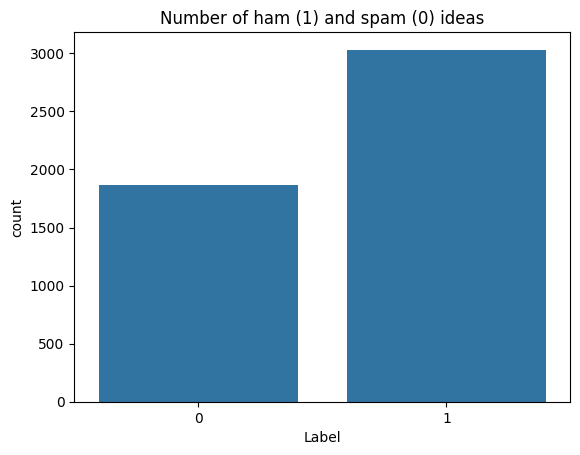

In [31]:
sns.countplot(df, x="spam")
plt.xlabel('Label')
plt.title('Number of ham (1) and spam (0) ideas')

In [32]:
X = df.sentence
Y = df.spam
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [33]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [34]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [35]:
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [1]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout
from keras.initializers import glorot_uniform, orthogonal

def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64, kernel_initializer=orthogonal())(layer)
    layer = Dense(256, name='FC1', kernel_initializer=glorot_uniform())(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer', kernel_initializer=glorot_uniform())(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [4]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

NameError: name 'max_len' is not defined

In [3]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

NameError: name 'model' is not defined

In [38]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [39]:
accr = model.evaluate(test_sequences_matrix,Y_test)

23/23 [==============================] - 0s 13ms/step - loss: 2.5931e-05 - accuracy: 1.0000


In [40]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.000
  Accuracy: 1.000


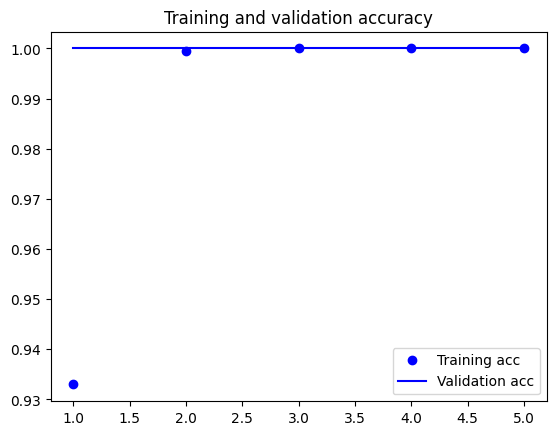

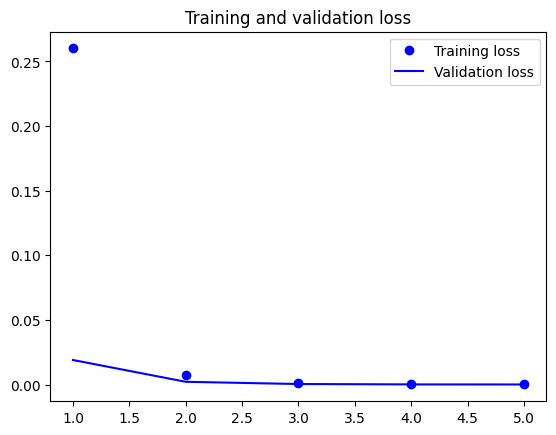

In [41]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [42]:
word_idx = 10
prediction = model.predict(test_sequences_matrix[word_idx:word_idx+10])
print(prediction, X_test[word_idx:word_idx+10])

1/1 [==============================] - 0s 226ms/step
[[3.3443706e-05]
 [9.9999976e-01]
 [3.0750514e-05]
 [9.9999988e-01]
 [9.9999905e-01]
 [9.9999940e-01]
 [9.9999976e-01]
 [1.6142920e-05]
 [1.0000000e+00]
 [9.9999642e-01]] 50                     Let me help you with your baggage.
2993    Đây là nền tảng phần mềm cho các hiệp hội nhà ...
71      Malls are great places to shop, I can find eve...
1839    Trong hơn hai năm, công ty đã làm việc trên mộ...
2380    Một nền tảng dữ liệu tài chính nhằm mục đích g...
1464    Một công ty giúp người dùng theo dõi dữ liệu c...
3923    Một công ty khởi nghiệp sử dụng dữ liệu từ điệ...
963            The scent of blooming jasmine in a garden.
4005     Một công ty cung cấp một cách thức để các côn...
2951    Một tủ lưu trữ kỹ thuật số cho lượng lớn dữ li...
Name: sentence, dtype: object


In [43]:
def input(new_sentence, ai_model):
  new_sentence = new_sentence + "."
  test_sequences = tok.texts_to_sequences([new_sentence])
  test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
  prediction = ai_model.predict(test_sequences_matrix)
  label = "spam"
  if prediction > 0.5:
    label = "innovative idea"
  print(prediction, new_sentence[:30] + '...')

In [44]:

input("Nghi is building an AI app for tracking habit automatically that use voice-over to record your daily activities", model)
input("Origin recipes for this manificient coffee shop", model)
input("This is the new way to play guitar", model)
input("This is the new book", model)
input("This is the new AI model helping homework completion", model)
input("We are operating new AI model to auto complete homework", model)
input("Instagram is so popular that now everyone is using, scrolling til tired", model)

1/1 [==============================] - 0s 70ms/step
[[7.950824e-05]] Nghi is building an AI app for...
1/1 [==============================] - 0s 16ms/step
[[9.171246e-05]] Origin recipes for this manifi...
1/1 [==============================] - 0s 15ms/step
[[3.1068626e-05]] This is the new way to play gu...
1/1 [==============================] - 0s 18ms/step
[[6.599057e-05]] This is the new book....
1/1 [==============================] - 0s 15ms/step
[[0.00031102]] This is the new AI model helpi...
1/1 [==============================] - 0s 14ms/step
[[0.00030305]] We are operating new AI model ...
1/1 [==============================] - 0s 16ms/step
[[0.00011535]] Instagram is so popular that n...


In [ ]:
input("SmartMirror Health Assistant: A cutting-edge innovation that combines a traditional mirror with advanced AI technology to create a personalized health monitoring system. The SmartMirror analyzes facial features and provides real-time health insights, such as heart rate, stress levels, and skin condition. It also offers personalized workout recommendations and nutrition tips based on individual goals. With voice control and integration with smart devices, the SmartMirror Health Assistant revolutionizes daily routines, empowers users to make informed health decisions, and promotes overall well-being in a seamless and interactive way.", model)

In [ ]:
input("Paperclip Organizer: A simple and practical solution for keeping paperclips organized and easily accessible. This compact organizer features separate compartments for different sizes and colors of paperclips, preventing them from getting lost or tangled. Its sleek design takes up minimal desk space, offering convenience and efficiency for everyday office tasks.", model)
input("A budget-friendly hotel chain providing comfortable accommodations, basic amenities, and convenient locations near popular attractions.", model)
input("A travel agency offering pre-packaged vacation deals to popular tourist destinations, with standard itineraries and accommodations.", model)

In [ ]:
docs = """
A travel agency that specializes in creating immersive cultural experiences for travelers
"""

In [13]:
input(docs, model)

NameError: name 'docs' is not defined

In [22]:
# Save the model to a file
model.save('../src/new_model/my_model.h5')

/Users/macos/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
from tensorflow.keras.models import load_model

model = load_model('../src/new_model/my_model.h5')

In [ ]:
import torch
from torch import nn

class MyModel(nn.Module):
    def __init__(self, max_words, max_len):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(max_words, 50, max_len)
        self.lstm = nn.LSTM(50, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Get the output of the last time step
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Example usage:
# model = MyModel(max_words=5000, max_len=100)


## PhoBERT Embedding - Vietnamese Spam Filtering

[Hugging Face - PhoBERT](https://huggingface.co/docs/transformers/model_doc/phobert)

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# INPUT TEXT MUST BE ALREADY WORD-SEGMENTED!
line = "Tôi là sinh_viên trường đại_học Công_nghệ ."

input_ids = torch.tensor([tokenizer.encode(line)])

with torch.no_grad():
  features = phobert(input_ids) # Models outputs are now tuples


In [4]:
!pip3 install underthesea

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 478.3/478.3 kB 2.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 11.8 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 574.9/574.9 kB 11.9 MB/s eta 0:00:00 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.2 MB/s eta 0:00:0031m13.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 11.7 MB/s eta 0:00:000:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 13.3 MB/s eta 0:00:00m eta 0:00:010:00:01
  Created wheel for python-crfsuite: filename=

In [ ]:
tag_sentence = 'Dịch vụ đặt vé trực tuyến của chúng tôi, EasyBooking, giúp bạn dễ dàng tìm kiếm, so sánh và đặt vé máy bay, khách sạn và tour du lịch. Với giao diện thân thiện và tính năng tiện lợi, chúng tôi mang đến trải nghiệm đặt vé nhanh chóng và tiết kiệm thời gian cho bạn'

In [ ]:
from underthesea import pos_tag, chunk, classify

pos_str = pos_tag(tag_sentence)
text_group = set([word for word,tag,num in chunk(tag_sentence) if tag == 'Np' or tag == 'N' or tag == 'V'])
# class_of_text = classify(tag_sentence)
nouns = set([word for word,tag in pos_str if tag == 'Np' or tag == 'N'])
print(text_group)

# Viet IDEA Spam Filtering

In [ ]:
!pip3 install pandas numpy seaborn matplotlib scikit-learn keras tensorflow gensim

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
# tf.keras.optimizers.legacy.RMSprop
from keras.src.optimizers.legacy.rmsprop import RMSprop
from keras.src.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
import pandas as pd

abs_path = '/Users/macos/Code/Graduation/share-your-idea/ml-server/'
invalid_1 = pd.read_csv(abs_path + "data/random_str.csv", delimiter=',')
invalid_0 = pd.read_csv(abs_path + "data/vie/spam.csv", delimiter=';')
semantic = pd.read_csv(abs_path + "data/vie/valid_idea.csv", delimiter=';', usecols=['sentence', 'spam'])

invalid_0.head()
invalid_1.head()
semantic.head()

frames = [invalid_0, semantic, invalid_1]
 
df = pd.concat(frames)

df.sample(10)

: 

Text(0.5, 1.0, 'Number of ham (1) and spam (0) ideas')

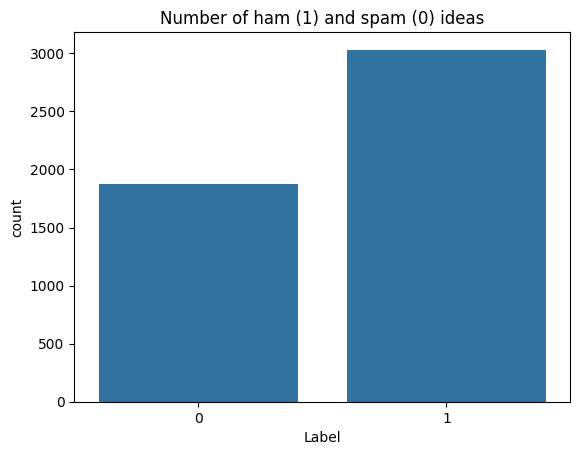

In [15]:
sns.countplot(df, x="spam")
plt.xlabel('Label')
plt.title('Number of ham (1) and spam (0) ideas')

In [16]:
X = df.sentence
Y = df.spam
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [17]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [18]:
# rnn_weights_file = 
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  # model.load_weights(rnn_weights_file)
  return model

In [64]:
import tensorflow as tf

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3) ## for mac
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [121]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Model

def RNN(max_len, max_words):
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

ModuleNotFoundError: No module named 'tensorflow.keras.layers'

In [ ]:
!pip3 install tensorflow keras

In [ ]:
!pip3 show tensorflow

In [65]:
history = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=3,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/3
27/27 [==============================] - 6s 136ms/step - loss: 0.4373 - accuracy: 0.8522 - val_loss: 0.1670 - val_accuracy: 0.9545
Epoch 2/3
27/27 [==============================] - 2s 86ms/step - loss: 0.0820 - accuracy: 0.9772 - val_loss: 0.0342 - val_accuracy: 0.9928
Epoch 3/3
27/27 [==============================] - 2s 77ms/step - loss: 0.0318 - accuracy: 0.9931 - val_loss: 0.0186 - val_accuracy: 0.9940


In [87]:
Y_train.shape

(4171, 1)

In [66]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [50]:
accr = model.evaluate(test_sequences_matrix,Y_test)

24/24 [==============================] - 0s 16ms/step - loss: 0.0422 - accuracy: 0.9851


In [51]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.042
  Accuracy: 0.985


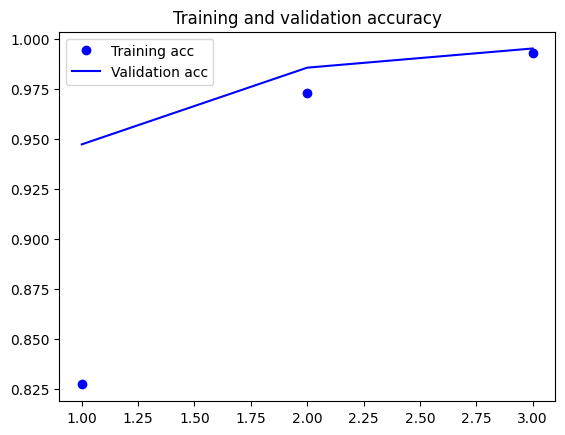

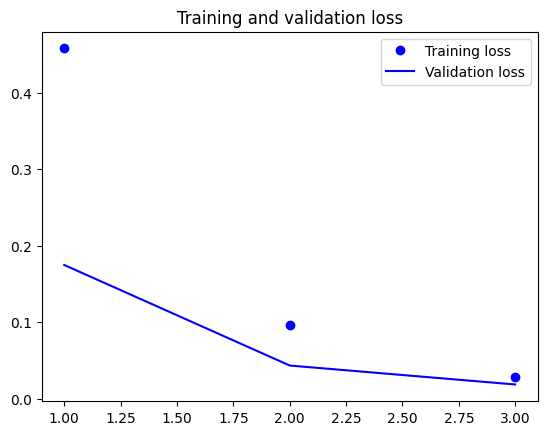

In [52]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [53]:
word_idx = 80
prediction = model.predict(test_sequences_matrix[word_idx:word_idx+5])
print(prediction, X_test[word_idx:word_idx+5])

1/1 [==============================] - 0s 326ms/step
[[0.99970335]
 [0.99652594]
 [0.04020244]
 [0.99343973]
 [0.9745758 ]] 454     Một nền tảng tiếp thị sử dụng máy học để thu t...
1071    Một công ty khởi nghiệp muốn đảm bảo rằng dữ l...
675     Những cái cây chết chờ đợi để được châm ngòi b...
2247    Một nền tảng cho vay được thiết kế để giúp ngư...
1855    Một startup giúp nhà tuyển dụng kết nối với nh...
Name: sentence, dtype: object


In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [54]:
import pickle

# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
# save the iris classification model as a pickle file
model_pkl_file = "../src/model/spam_filtering.pkl"  
model_json_file = "../src/model/spam_filtering.json"
model_weights_file = "../src/model/weights.h5py"


# serialize model to JSON
model_json = model.to_json()
with open(model_json_file, 'w') as file:  
  file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_weights_file)

In [67]:
from keras.models import load_model, save_model

# Assuming you have a model named 'model'

save_model_file='../src/model/lstm.keras'
save_model(model, save_model_file)  # Save the model to a HDF5 file
# model.save(save_model_file)

In [ ]:
# Load the model from the saved HDF5 file
save_model_file='../src/model/lstm.keras'
model = load_model(save_model_file)

In [99]:
!pip3 show keras

Name: keras
Version: 2.14.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /Users/macos/Library/Python/3.9/lib/python/site-packages
Requires: 
Required-by: tensorflow-macos


In [102]:
!pip3 show tensorflow

Name: tensorflow
Version: 2.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/macos/Library/Python/3.9/lib/python/site-packages
Requires: tensorflow-macos
Required-by: 


In [27]:
def input(new_sentence, ai_model):
  new_sentence = new_sentence + "."
  test_sequences = tok.texts_to_sequences([new_sentence])
  test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
  prediction = ai_model.predict(test_sequences_matrix)
  label = "SPAM"
  if prediction > 0.5:
    label = "VALID"
  print(prediction, label, new_sentence[:30] + '...')
  # print(test_sequences_matrix)

In [37]:
docs = """Một ống kính độ dài 2.5cm đang chỉa thẳng xuống mặt đất để đo đạc và chụp lại""" #Spam

In [30]:
docs = """MR.Bean là một sản phẩm tái tạo năng lượng bằng hệ thống xử lí chất thải sinh học tự động""" #Spam

In [22]:
docs = """Agelina - đứa con của công ty mẹ Egosh, là sàn thương mại điện tử nức tiếng nước Đức""" #Spam

In [28]:
docs = """"SmartMirror Health Monitor" là một hệ thống kết hợp gương trang điểm thông minh với chức năng theo dõi sức khỏe. Gương sẽ hiển thị thông tin về nhịp tim, nhiệt độ cơ thể và các thông số sức khỏe khác. Ngoài ra, nó cũng cung cấp các gợi ý về dinh dưỡng và chế độ tập luyện dựa trên dữ liệu cá nhân. SmartMirror Health Monitor giúp người dùng theo dõi sức khỏe một cách thuận tiện trong khi trang điểm hoặc thay đồ hàng ngày.""" #Valid

In [29]:
docs = """Exlaix là một hệ thống xác thực hai yếu tố mạnh mẽ và dễ sử dụng. Hệ thống này sẽ kết hợp việc yêu cầu mật khẩu độc đáo cùng với mã xác thực được gửi đến điện thoại di động của chủ sở hữu kênh mỗi khi có hoạt động đăng nhập từ một thiết bị mới. Ngoài ra, việc cung cấp các công cụ giám sát hoạt động đăng nhập từ các địa điểm không thường xuyên hoặc từ các thiết bị không xác định cũng là một phương tiện hiệu quả để nhận biết và ngăn chặn các nỗ lực tấn công""" #Valid

In [55]:
docs = """Sản phẩm TechSmart đem đến cho bạn sự tiện ích và khả năng kết nối thông minh. Với tính năng đột phá và hiệu suất cao, chúng tôi giúp bạn trải nghiệm công nghệ tối ưu và tận hưởng cuộc sống hiện đại""" #Spam

In [38]:
input(docs, model)

1/1 [==============================] - 0s 20ms/step
[[0.03636729]] SPAM Một ống kính độ dài 2.5cm đang...


### Gibberish Detector

In [1]:
!pip3 install gibberish-detector

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!gibberish-detector train data/WIKI.txt > vie.model

zsh:1: command not found: gibberish-detector


In [ ]:
from gibberish_detector import detector

# open('data/WIKI.txt')

Detector = detector.create_from_model('vie.model')
print(Detector.is_gibberish('Chào, tớ là osijd lldkn qwoie')) #Gibberish

In [31]:
import pandas as pd
import sys
from underthesea import chunk, pos_tag
from keras.models import Sequential, model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from gensim import models
from gibberish_detector import detector
import pickle

model_json_file = "../src/model/spam_filtering.json"
model_weights_file = "../src/model/weights.h5py"
word2vec_path='../src/model/word2vec.vie.model.bin'
gibberish_path='../src/model/gibberish.vie.model'
max_words = 1000
max_len = 150

# with open(model_json_file, 'r') as file:  
#   json_model = file.read()
#   lstm_model = model_from_json(json_model)
#   lstm_model.load_weights(model_weights_file)
#   lstm_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=['accuracy'])

class SpamFiltering:
  def __init__(self, lstm_model) -> None:
    self.tokenizer = Tokenizer(num_words=max_words)
    self.detector = detector.create_from_model(gibberish_path)
    self.lstm_model = lstm_model

  def is_idea_spam(self, idea_object):
    desc = [idea_object.solution + '.']
    print(desc)
    if self.detector.is_gibberish(desc):
      return "SPAM"
    self.tokenizer.fit_on_texts(desc)
    test_sequences = self.tokenizer.texts_to_sequences(desc)
    test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
    print(test_sequences)
    prediction = self.lstm_model.predict(test_sequences_matrix)
    # prediction = model.predict(test_sequences_matrix)
    label = "SPAM"
    if prediction > 0.5:
      label = "VALID"
    elif prediction > 0.3:
      label = "WARNING"
    print(prediction, f' -> {label} :: "{desc[:30]}..."')
    return label

In [34]:
class IdeaObj:
  def __init__(self,problem='',solution='') -> None:
    self.problem=problem
    self.solution=solution

In [36]:
def main():
  try:
    lstm_model=None
    with open(model_json_file, 'r') as file:  
      json_model = file.read()
      lstm_model = model_from_json(json_model)
      lstm_model.load_weights(model_weights_file).expect_partial()
      # lstm_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-3),metrics=['accuracy'])
    spam = SpamFiltering(lstm_model)
    problem='tài chính'
    solution="Một ứng dụng cho phép người dùng quản lí tài chính cá nhân bằng trực quan hóa số liệu và hỗ trợ quyết định đầu tư, tiết kiệm."
    solution="""Ứng dụng kết hợp với cảm biến đất, ánh sáng và nước để giám sát và quản lý cây trồng. Người dùng sẽ nhận được thông báo để tưới nước, bón phân và chăm sóc cây đúng cách, tạo điều kiện tối ưu cho sự phát triển và sức khỏe của cây."""
    idea = IdeaObj(problem=problem, solution=solution)
    spam.is_idea_spam(idea)
  except ValueError as ve:
    return str(ve)

main()

['Ứng dụng kết hợp với cảm biến đất, ánh sáng và nước để giám sát và quản lý cây trồng. Người dùng sẽ nhận được thông báo để tưới nước, bón phân và chăm sóc cây đúng cách, tạo điều kiện tối ưu cho sự phát triển và sức khỏe của cây..']
[[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 3, 4, 15, 16, 1, 17, 18, 2, 19, 20, 21, 22, 23, 24, 25, 26, 4, 27, 3, 28, 29, 1, 30, 31, 2, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 1, 43, 44, 45, 2]]
1/1 [==============================] - 0s 307ms/step
[[0.99994195]]  -> VALID :: "['Ứng dụng kết hợp với cảm biến đất, ánh sáng và nước để giám sát và quản lý cây trồng. Người dùng sẽ nhận được thông báo để tưới nước, bón phân và chăm sóc cây đúng cách, tạo điều kiện tối ưu cho sự phát triển và sức khỏe của cây..']..."


# PyTorch RNN

In [98]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

In [94]:
import torch
import torch.nn as nn

max_words = 1000
max_len = 150

class RNN(nn.Module):
    def __init__(self, max_words = max_words , max_len = max_len):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(max_words, 50)
        self.lstm = nn.LSTM(50, 64, batch_first=True)
        self.fc1 = nn.Linear(64, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs):
        embed = self.embedding(inputs)
        lstm_out, _ = self.lstm(embed)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
        fc1_out = self.relu(self.fc1(lstm_out))
        fc1_out = self.dropout(fc1_out)
        out = self.sigmoid(self.fc2(fc1_out))
        return out

# Define the maximum number of words and maximum length
max_words = 10000  # Example value, replace with actual value
max_len = 150  # Example value, replace with actual value

# Instantiate the model
model = RNN(max_words, max_len)

In [93]:
import torch

class CustomDataset:
    def __init__(self,reviews,sentiments):
        self.reviews = reviews
        self.sentiments = sentiments
        
    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = self.reviews[item,:]
        target = self.sentiments[item]
        return {
            "review": torch.tensor(review,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [92]:
# Example usage
text = "Hôm nay là một ngày đẹp trời."
tokens = tokenizer(text, padding='max_length', truncation=True, max_length=50, return_tensors='pt')
tokens['input_ids'][0]

tensor([    0,  3248,   136,     8,    16,    43,   258,  2127, 16907, 27375,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1])

In [96]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
from torch.optim import Adam
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function

learning_rate = 0.0001
batch_size = 128
num_epochs = 5

# Define loss function and optimizer
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()  # Use appropriate loss function
optimizer = Adam(model.parameters(), lr=learning_rate)

dataset = CustomDataset(df)

# Create a PyTorch DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate the model
model = RNN(tokenizer.vocab_size, 50)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    for inputs, targets in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # Accumulate the total loss
        total_loss += loss.item() * len(inputs)

    # Compute the average training loss for the epoch
    avg_train_loss = total_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
def run(df):
    y = df.sentiment.values
    train_df,valid_df = train_test_split(df,test_size = 0.2, stratify = y)
    
    print('Fitting tokenizer')
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(df.review.values.tolist())
    
    xtrain = tokenizer.texts_to_sequences(train_df.review.values)
    xtest = tokenizer.texts_to_sequences(valid_df.review.values)
    xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
    xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
    train_dataset = CustomDataset(reviews=xtrain,sentiments=train_df.sentiment.values)
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=TRAIN_BATCH_SIZE,num_workers=2)
    valid_dataset = CustomDataset(reviews=xtest,sentiments=valid_df.sentiment.values)
    valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=VALID_BATCH_SIZE,num_workers=2)
    
    print("Load embeddings")
    embedding_dict = load_vectors('../input/glove-embeddings/glove.6B.300d.txt')
    embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)
    # create a torch device since we are using cuda
    device = torch.device("cuda")
    model = LSTM(embedding_matrix)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
    print("Traning model")
    best_accuracy = 0
    early_stopping_counter = 0
    for epoch in range(1,EPOCHS+1):
        train(train_loader,model,optimizer,device)
        outputs,targets = evaluate(valid_loader,model,device)
        outputs = np.array(outputs)>0.5
        accuracy = metrics.accuracy_score(targets,outputs)
        print(f"EPOCH:{epoch}, Accuracy Score: {accuracy}")
        if accuracy>best_accuracy:
            best_accuracy = accuracy
        else:
            early_stopping_counter +=1
        if early_stopping_counter>2:
            break
            
            

: 